In [1]:
#utils
import emoji, re, string, time, os
from utils import get_test_metrics
from utils import preprocess
from utils import get_user_features, get_top_users
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle
import math

#nlp
import nltk
from nltk.corpus import stopwords
import spacy
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split

#models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")

In [2]:
def optimal_threshold(prob,y):
    best_thresold = 0
    best_score = 0
    
    for i in range(100):
        threshold = i/100
        y_pred = [1 if p >= threshold else 0 for p in prob]
        score = metrics.accuracy_score(y,y_pred)
        
        if score > best_score:
            #print(score)
            best_thresold = threshold
            best_score = score
            
    return best_thresold

# optimal mlp for tfidf
def get_mlp():
    clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-3, verbose = False, early_stopping = True, 
                   n_iter_no_change = 10, max_iter = 200,
                   hidden_layer_sizes = (100,), alpha = 0.0067, 
                   learning_rate_init = .00026, batch_size = 50)
    return clf

# tunning hyperparameters mlp
n_iter = 10
def random_layers():
    '''
    Create a tuple random of hidden_layer_sizes. 
    '''
    n_layers = np.random.randint(1,4)
    layers_list = []
    for i in range(n_layers):            
        hidden_neurons = np.random.randint(1,15)*25
        layers_list.append(hidden_neurons)
    layers_tuple = tuple(layers_list)
    return layers_tuple

def random_search_mlp(X_train,y_train,n_iter=10):
    
    # hyperparams to optimize
    hidden_layers = []
    alphas = []
    batch_sizes = []
    learning_rate_inits = []
    # sample
    np.random.seed(0)
    for i in range(n_iter):   
        hl = random_layers()
        #print(hl,end = '; ')
        hidden_layers.append(hl)
        ap = 10**np.random.uniform(-6,-2)
        #print(ap, end = '; ')
        alphas.append(ap)
        learning = 10**np.random.uniform(-4,-1)
        #print(learning, end = '; ')
        learning_rate_inits.append(learning)
        batch = np.random.randint(1,7)*50 #math.floor(10**np.random.uniform(1.5,2.6)) #np.random.randint(2,30)*10
        #print(batch)
        batch_sizes.append(batch)

    # tunning
    X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    best_score = 0
    i = 0
    for hl,bs,al,lri in zip(hidden_layers,batch_sizes,alphas,learning_rate_inits):
        
        clf = optimized_mlp(hl,bs,al,lri)

        print(i, end= ' ')
        i+=1
        print()
        print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))    
        clf.fit(X_train_v, y_train_v)
        y_pred = clf.predict(X_val)        
        y_prob = clf.predict_proba(X_val)[:,1]
        
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_prob, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        print('AUC: {a:.3f}'.format(a=roc_auc))       
        if roc_auc > best_score:
            best_score = roc_auc
            best_params = (hl,bs,al,lri)

        #print('validation rmse: {a:.3f}'.format(a=rmse))


    hl,bs,al,lri = best_params
    print()
    print('--------------------')
    print('BEST PARAMETERS (validation AUC = {a:.3f})'.format(a=best_score))
    print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))
    print('--------------------')
    return hl,bs,al,lri

def optimized_mlp(hl,bs,al,lri):
    clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-4, verbose = False, early_stopping = True, 
                   n_iter_no_change = 10, max_iter = 100,
                   hidden_layer_sizes = hl, alpha = al, 
                   learning_rate_init = lri, batch_size = bs)
    return clf

def train_test(clf,X_train,X_test,y_train,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]
    test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)
    return test_metrics
    


In [3]:
# data correction
# df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
# df['misinformation'] = [mis if sha > 1 else -1 for mis,sha in zip(df['misinformation'], df['shares'])]
# df.head()
# df.to_csv('data/2018/fakeWhatsApp.BR_2018.csv',index=False)

# Dataset expansion

In [3]:
# messages
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df_texts = pd.read_csv('data/2018/fakeWhatsApp.BR_2018_preprocessed_texts.csv')
df = pd.concat([df, df_texts], axis=1)
df.drop(columns=['Unnamed: 0'],inplace=True)
corpus = list(df[df['midia']==0]['preprocessed_text_lemma'].unique())
print('size total data:',len(df))

print('manually labelled messages:',len(df[df['shares']>1]))

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


size total data: 282601
manually labelled messages: 20872


In [4]:
df_labelled = df[df['shares']>1].drop_duplicates(subset=['text'])
print('unique manually labelled messages',len(df_labelled))

unique manually labelled messages 5284


In [5]:
X = df_labelled['text']
y = df_labelled['misinformation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

In [104]:
#9.19*(len(df)/5000)/60
#df = df[0:5000]

In [7]:
hidden_midia = '<Arquivo de mídia oculto>'
threshold = 0.8

labelled_texts = list(X_train)
labels = list(y_train)
non_labelled_texts = list(df['text'])
test_texts = list(X_test)

# vectorize non-labelled and labelled
vectorizer = TfidfVectorizer()
non_labelled_tfidf = vectorizer.fit_transform(non_labelled_texts)  
tfidf_labels = vectorizer.transform(labelled_texts)
non_labelled_tfidf_list = list(non_labelled_tfidf)

best_msgs = []
best_labels = []
best_dists = []

cen = int(len(non_labelled_tfidf_list)/10)

start_loop = time.time()
start_time = time.time()
for i,msg in enumerate(non_labelled_tfidf_list):
    
    if(i%cen==0):
        ith = int(i/cen + 1)
        print(str(ith) + '/10')
        end_time = time.time()
        print('time ellapsed since last 10%:',end_time-start_time)
        start_time = time.time()
        
    if non_labelled_texts[i] == hidden_midia or non_labelled_texts[i] in test_texts:
#         best_labels.append(-1)
#         best_msgs.append(None)
#         best_dists.append(0) 
        continue
        
    cosine_similarities = linear_kernel(msg, tfidf_labels).flatten()
    best_match_ix = np.argmax(cosine_similarities)
    sim = np.max(cosine_similarities)
    
    if sim < threshold:
        continue
#         best_labels.append(-1)
#         best_msgs.append(None)
        
    else:
        best_labels.append(labels[best_match_ix])
        best_msgs.append(labelled_texts[best_match_ix])
        best_dists.append(sim)       
        
end_loop = time.time()
print('time ellapsed:',end_loop-start_loop)

1/10
time ellapsed since last 10%: 0.0002627372741699219
2/10
time ellapsed since last 10%: 66.53936767578125
3/10
time ellapsed since last 10%: 65.82188963890076
4/10
time ellapsed since last 10%: 59.45518183708191
5/10
time ellapsed since last 10%: 60.14853358268738
6/10
time ellapsed since last 10%: 76.85988879203796
7/10
time ellapsed since last 10%: 84.7689299583435
8/10
time ellapsed since last 10%: 76.94213509559631
9/10
time ellapsed since last 10%: 82.89926242828369
10/10
time ellapsed since last 10%: 78.87689971923828
11/10
time ellapsed since last 10%: 87.98940920829773
time ellapsed: 740.3423891067505


In [12]:
y_train_exp = y_train.append(pd.Series(best_labels), ignore_index=True)
X_train_text_exp = X_train.append(pd.Series(best_msgs), ignore_index=True)

# Select texts and labels

In [8]:
# select data
#texts
original_texts = df['text']
texts = df['preprocessed_text_lemma']
#target
y = df['misinformation']

data balance in dataset


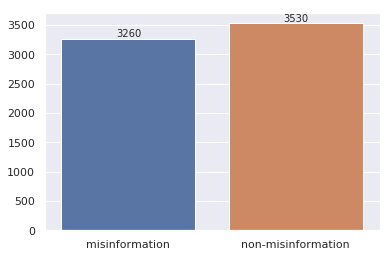

In [9]:
def print_class_balance(y):
    pos_mask = y == 1 
    pos = y[pos_mask]
    neg_mask = y == 0 
    neg = y[neg_mask]
    values = [pos.shape[0],neg.shape[0]]
    keys = ['misinformation', 'non-misinformation']
    g = sns.barplot(x = keys, y = values)
    for p in g.patches:
        g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                                   p.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, 5), textcoords = 'offset points')
print('data balance in dataset')        
print_class_balance(y)

# Train-test split by time

In [32]:
len(corpus)

99016

# BoW

In [14]:
#vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), lowercase = True, token_pattern = r'[^\s]+')
vectorizer = CountVectorizer(max_features = None, ngram_range = (1,3), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+',binary=True)
vectorizer.fit(X_train_text_exp)   
X_train_exp = vectorizer.transform(X_train_text_exp)
X_test = vectorizer.transform(X_test)
X_train_exp.shape

(24132, 415917)

In [ ]:
print(vectorizer.get_feature_names()[100:150])

In [15]:
print('logistic regression + binary bow')
clf = LogisticRegression()
clf.fit(X_train_exp,y_train_exp)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train_exp)[:,1]
# threshold moving


logistic regression + binary bow


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ValueError: Found input variables with inconsistent numbers of samples: [4227, 24132]

0.32
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       618
           1       0.71      0.71      0.71       439

    accuracy                           0.76      1057
   macro avg       0.75      0.75      0.75      1057
weighted avg       0.76      0.76      0.76      1057

AUC:  0.8298058989613051


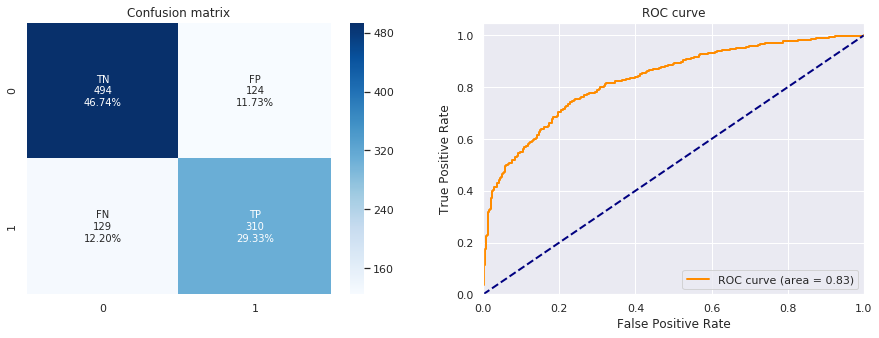

(0.760643330179754,
 0.7142857142857143,
 0.7961321514907334,
 0.7061503416856492,
 0.7961321514907334,
 0.7101947308132874,
 0.7961321514907334,
 0.8298058989613051)

In [16]:
#thr = optimal_threshold(y_prob,y_test)
thr = optimal_threshold(y_prob_train,y_train_exp)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

In [ ]:
print('mlp + bow')
clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-3, verbose = True, early_stopping = True, 
                   n_iter_no_change = 3, max_iter = 20,
                   hidden_layer_sizes = (100,), alpha = .0001, 
                   learning_rate_init = .0001, batch_size = 200)

clf.fit(X_train,y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Topic modelling (LDA)

In [133]:
# # topics
# from gensim.models import LdaModel
# from gensim.corpora.dictionary import Dictionary
# n_topics = 15

# def train_lda(corpus, n_topics = 100):
#     common_texts = [x.split() for x in corpus]
#     common_dictionary = Dictionary(common_texts)
#     common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
#     lda = LdaModel(common_corpus, num_topics=n_topics)
#     return lda, common_dictionary

# lda, common_dictionary = train_lda(X_train_texts, n_topics)

In [134]:
# # vectorizing
# def tup2array(tuples,n_topics):
#     topics = np.zeros(n_topics)
#     for t, p in tuples:
#         topics[t] = p
#     return topics

# def vectorize_topics(X,lda):
#     X = [lda[x] for x in X]
#     X = [tup2array(v,lda.num_topics) for v in X]
#     return X

# def texts2topics(texts,lda):
#     X = [x.split() for x in texts]
#     X = [common_dictionary.doc2bow(text) for text in X]
#     X = vectorize_topics(X,lda)
#     return X
    

# X_train_topics = texts2topics(X_train_texts,lda)
# X_test_topics = texts2topics(X_test_texts,lda)

In [135]:
# print('logistic regression + lda')
# clf = LogisticRegression()
# clf.fit(X_train_topics,y_train)
# y_prob = clf.predict_proba(X_test_topics)[:,1]
# y_prob_train = clf.predict_proba(X_train_topics)[:,1]
# thr = optimal_threshold(y_prob_train,y_train)
# print(thr)
# y_pred = [1 if p >= thr else 0 for p in y_prob]
# test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

In [136]:
# print('mlp + lda')
# # clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
# #                    tol = 1e-3, verbose = True, early_stopping = True, 
# #                    n_iter_no_change = 3, max_iter = 100,
# #                    hidden_layer_sizes = (100,), alpha = .00001, 
# #                    learning_rate_init = .0001, batch_size = 32)
# # hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# # clf = optimized_mlp(hl,bs,al,lri)

# # results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)
# clf.fit(X_train_topics,y_train)
# y_prob = clf.predict_proba(X_test_topics)[:,1]
# y_prob_train = clf.predict_proba(X_train_topics)[:,1]
# thr = optimal_threshold(y_prob_train,y_train)
# print(thr)
# y_pred = [1 if p >= thr else 0 for p in y_prob]
# test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Word embeddings

In [137]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

In [138]:
len(corpus)

99016

In [139]:
class EpochLogger(CallbackAny2Vec):
    """Callback to log information about training"""

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        self.epoch += 1
        print("W2V: Epoch #{}".format(self.epoch))
        
epoch_logger = EpochLogger()

w2v = Word2Vec(min_count=1)
w2v.build_vocab(corpus)  # prepare the model vocabulary
w2v.train(corpus, total_examples=w2v.corpus_count, 
            epochs=15, compute_loss=True, 
            callbacks=[epoch_logger])

w2v.save("data/2018/word2vec_train.model")

w2v = Word2Vec.load("data/2018/word2vec_train.model")

W2V: Epoch #1
W2V: Epoch #2
W2V: Epoch #3
W2V: Epoch #4
W2V: Epoch #5
W2V: Epoch #6
W2V: Epoch #7
W2V: Epoch #8
W2V: Epoch #9
W2V: Epoch #10
W2V: Epoch #11
W2V: Epoch #12
W2V: Epoch #13
W2V: Epoch #14
W2V: Epoch #15


In [140]:
w2v.most_similar(positive=['deus'])

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('dars', 0.7146254181861877),
 ('vosso', 0.6393389105796814),
 ('senhor', 0.6037132143974304),
 ('cristo', 0.5999789834022522),
 ('orar', 0.5988916754722595),
 ('ceus', 0.5961741209030151),
 ('oracao', 0.589393138885498),
 ('paz', 0.5810234546661377),
 ('ti', 0.580318808555603),
 ('coracao', 0.5780038237571716)]

In [141]:
def vectorize_text(model, text, method='mean'):
        """
        Convert all words in a text to their embedding vector
        and calculate a vector for the text, by the mean or the sum of word vectors
        Parameters
        ----------
        text: str
        Text from wich the word vector's will be calculated    
        
        method: str
        'mean' or 'sum'
            
        Returns
        -------
        vec: numpy.ndarray 
        Array of the word embeddings from the given text 
        """
        n = model.vector_size
        X = np.empty(shape=[0, n])
        words = text.split()
        for word in words:
            try:
                vec = model[word]
                X = np.append(X,[vec], axis = 0)
            # if oov:    
            except:
                #print('word not in vocabulary: ', word)
                continue
        if X.size == 0:
            vec = np.zeros(n)
        elif method == 'mean':
            vec = np.mean(X,axis=0)
        elif method == 'sum':
            vec = np.sum(X,axis=0)
        return vec
    
def vectorize_corpus(model, corpus, method='mean'):
        """
        Convert all texts in a corpus to vectors
        Parameters
        ----------
        corpus: list
        List of texts    
        
        method: str
        'mean' or 'sum'
            
        Returns
        -------
        X: numpy.ndarray 
        2D Array of vectors from each text in corpus
        """
        X = [vectorize_text(model, text, method=method) for text in corpus]
        X = np.concatenate(X, axis=0).reshape(len(X),len(X[0]))
        return X

x = vectorize_corpus(w2v, 'bolsonaro é um prego')
x

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


array([[ 0.76043952,  0.88879251, -0.90697527, ...,  2.15013814,
         0.7196781 ,  0.28560203],
       [ 3.00207233, -4.6533699 , -0.19180547, ..., -0.1885826 ,
        -1.59377575,  0.92375523],
       [-0.58913201,  0.45220304,  0.12042369, ...,  2.04464436,
         0.13235311, -0.52890253],
       ...,
       [-0.42522535, -0.17314038, -0.21733224, ...,  0.18411075,
         0.0935633 , -0.13170595],
       [-0.26353815,  0.03204688, -0.65704316, ..., -0.42762509,
        -1.10094047, -0.71728772],
       [ 3.00207233, -4.6533699 , -0.19180547, ..., -0.1885826 ,
        -1.59377575,  0.92375523]])

In [142]:
X_train = vectorize_corpus(w2v,X_train_texts)
X_test = vectorize_corpus(w2v,X_test_texts)

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


logistic regression + w2v
0.46
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       655
           1       0.69      0.72      0.70       703

    accuracy                           0.68      1358
   macro avg       0.68      0.68      0.68      1358
weighted avg       0.68      0.68      0.68      1358

AUC:  0.7441738242863192


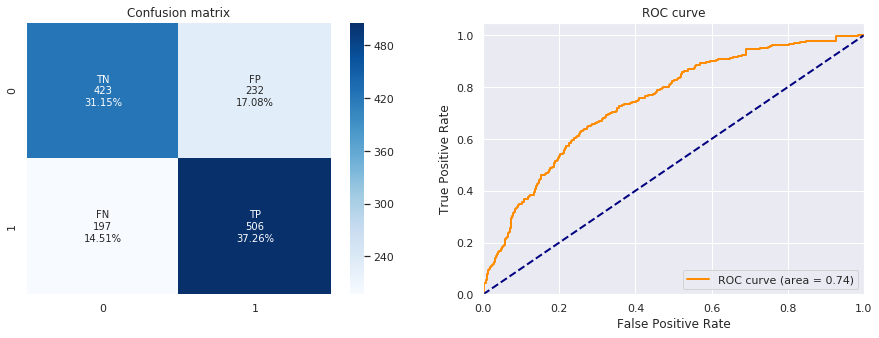

In [143]:
print('logistic regression + w2v')
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + w2v
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
AUC: 0.877
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
AUC: 0.885
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
AUC: 0.878
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
AUC: 0.911
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
AUC: 0.886
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
AUC: 0.874
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
AUC: 0.897
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
AUC: 0.892
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
AUC: 0.877
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
AUC: 0.887
10 
hidden layers: (75, 300, 25); alpha: 0.00002; learning rate: 0.0012

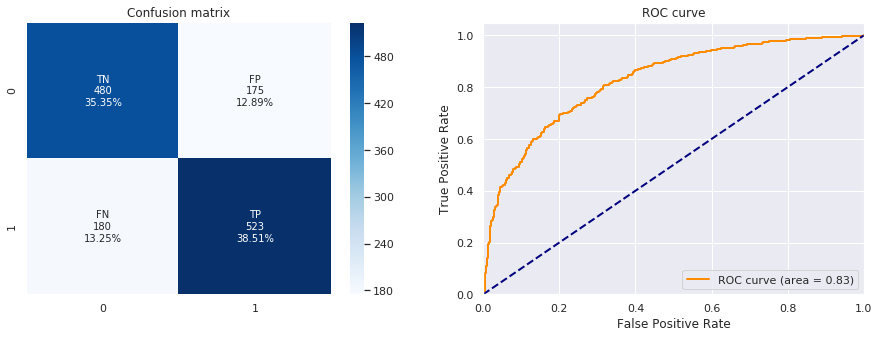

In [144]:
print('mlp + w2v')
# clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
#                    tol = 1e-3, verbose = True, early_stopping = True, 
#                    n_iter_no_change = 3, max_iter = 100,
#                    hidden_layer_sizes = (100,), alpha = .00001, 
#                    learning_rate_init = .0001, batch_size = 32)
# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)

# results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter=20)
clf = optimized_mlp(hl,bs,al,lri)
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Doc2Vec

In [145]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)
model.save('data/2018/doc2vec.model')

doc2vec = Word2Vec.load("data/2018/doc2vec.model")

In [146]:
doc2vec.infer_vector(['bolsonaro','meu','ovo'])

array([-6.6602312e-02, -3.4949172e-02, -4.9710464e-02, -4.2498123e-02,
       -1.2360432e-02,  1.3445731e-02,  6.4053880e-03, -2.5431946e-02,
       -1.3398189e-02,  3.2861233e-02,  1.9098092e-02, -2.7876189e-02,
        6.3099982e-03, -3.1566672e-02, -3.1930435e-02, -1.0488373e-02,
       -4.1927681e-03,  1.5584757e-02, -7.0700116e-05, -3.9354652e-02,
       -1.0245880e-02,  1.4009416e-02,  4.0548917e-02,  3.9947737e-02,
        8.7503903e-03, -2.1188991e-02, -5.8014154e-02,  1.2945187e-03,
       -8.7645007e-03,  2.9913289e-03,  1.0643284e-02,  2.2884613e-02,
       -1.0495075e-02,  6.5721613e-03,  3.7700005e-02, -4.1312732e-02,
       -1.1737006e-02,  3.6062714e-02,  4.1949291e-02, -5.9720329e-03,
       -3.1339686e-04,  1.1771470e-02, -1.9825641e-02, -3.3737447e-02,
       -3.6152098e-02,  5.4852455e-03, -1.1186537e-02, -4.1857189e-03,
        1.6273582e-02,  2.3028158e-02, -3.7187722e-02,  1.7717843e-03,
        9.8573705e-03, -1.4747194e-03, -1.8118804e-02, -9.9917008e-03,
      

In [147]:
def vectorize_doc2vec(model,text):
    text = text.split()
    vector = model.infer_vector(text)
    return vector

def vectorize_corpus_doc2vec(model,corpus):
    X = [vectorize_doc2vec(model, text) for text in corpus]
    X = np.concatenate(X, axis=0).reshape(len(X),len(X[0]))
    return X

X_train = vectorize_corpus_doc2vec(doc2vec, X_train_texts)
X_test = vectorize_corpus_doc2vec(doc2vec, X_test_texts)

logistic regression + doc2vec
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       655
           1       0.68      0.62      0.65       703

    accuracy                           0.65      1358
   macro avg       0.65      0.65      0.65      1358
weighted avg       0.65      0.65      0.65      1358

AUC:  0.7228323542505946


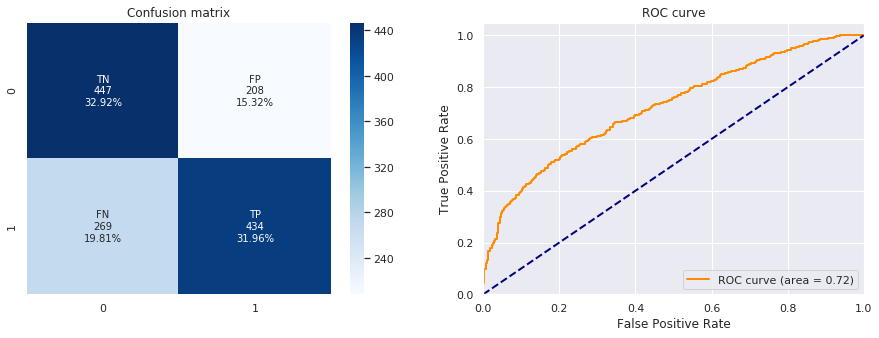

(0.6487481590574374,
 0.67601246105919,
 0.6520787746170679,
 0.6173541963015647,
 0.6520787746170679,
 0.645353159851301,
 0.6520787746170679,
 0.7228323542505946)

In [148]:
print('logistic regression + doc2vec')
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + doc2vec
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
AUC: 0.865
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
AUC: 0.848
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
AUC: 0.864
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
AUC: 0.884
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
AUC: 0.859
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
AUC: 0.837
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
AUC: 0.873
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
AUC: 0.869
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
AUC: 0.869
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
AUC: 0.863
10 
hidden layers: (75, 300, 25); alpha: 0.00002; learning rate: 0.

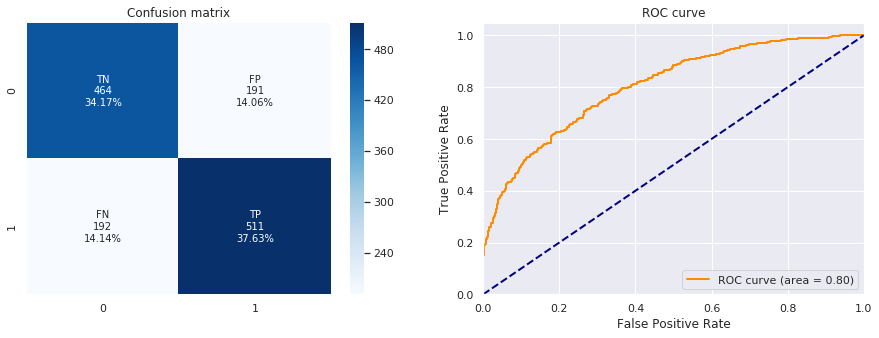

In [149]:
print('mlp + doc2vec')
# clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
#                    tol = 1e-3, verbose = True, early_stopping = True, 
#                    n_iter_no_change = 3, max_iter = 100,
#                    hidden_layer_sizes = (100,), alpha = .00001, 
#                    learning_rate_init = .0001, batch_size = 32)
# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)

# results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter=50)
clf = optimized_mlp(hl,bs,al,lri)
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Test model with messages about covid-19 collected from WhatsApp in 2020

In [21]:
df_2020 = pd.read_csv('data/2020/FakeWhatsApp2020.csv')
print('orignal size',len(df_2020))

df_2020 = df_2020.dropna(subset=['misinformation','text'])
df_2020['types'] = [len(set(t.split())) for t in df_2020['text']]
df_2020 = df_2020[(df_2020['types']>15) & (df_2020['revision']!=1)]
print('size after filtering',len(df_2020))
df_2020.head()

orignal size 2899
size after filtering 1261


,shares,text,misinformation,source,revision,types
0,27,"O ministro da Ciência, Tecnologia, Inovações e...",0,https://www.gov.br/pt-br/noticias/educacao-e-p...,NaN,61
1,26,Pesquisa com mais de 6.000 médicos em 30 paíse...,1,https://www.aosfatos.org/noticias/e-falso-que-...,NaN,19
2,25,É com muita alegria que comunico que mais um p...,0,http://portal.mec.gov.br/component/content/art...,NaN,77
3,25,Renda Brasil unificará vários programas sociai...,0,https://agenciabrasil.ebc.com.br/politica/noti...,NaN,50
5,24,"“O que mais queremos é voltar à normalidade, e...",0,NaN,NaN,64


In [22]:
texts_test = [preprocess(t, lemma = True) for t in df_2020['text']]
y_test = df_2020['misinformation']

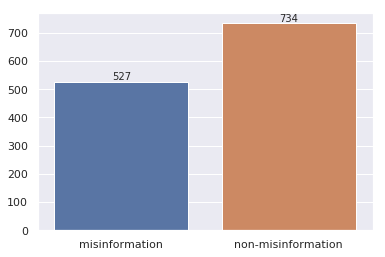

In [23]:
print_class_balance(y_test)

In [24]:
texts_train = df['preprocessed_text_lemma']
#target
y_train = df['misinformation']

In [25]:
#vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), lowercase = True, token_pattern = r'[^\s]+')
vectorizer = CountVectorizer(max_features = None, ngram_range = (1,3), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+',binary=True)
vectorizer.fit(texts_train)   
X_train = vectorizer.transform(texts_train)
X_test = vectorizer.transform(texts_test)
X_train.shape

(6790, 375893)

logistic regression + binary bow
0.42
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       734
           1       0.70      0.57      0.63       527

    accuracy                           0.72      1261
   macro avg       0.72      0.70      0.70      1261
weighted avg       0.72      0.72      0.71      1261

AUC:  0.7822800386745188


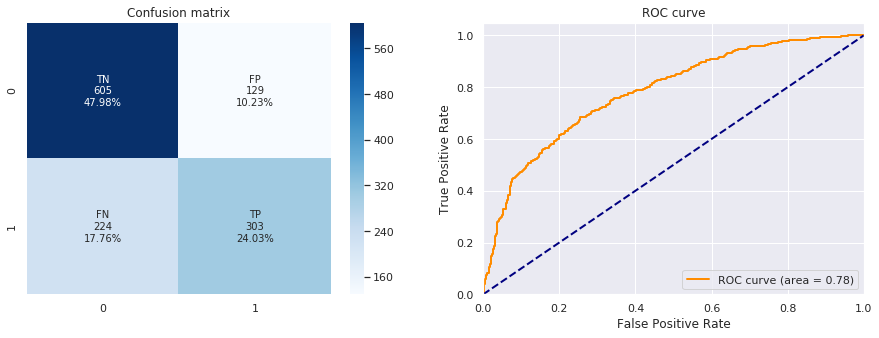

(0.7200634417129262,
 0.7013888888888888,
 0.7741522712731925,
 0.5749525616698292,
 0.7741522712731925,
 0.6319082377476538,
 0.7741522712731925,
 0.7822800386745188)

In [28]:
print('logistic regression + binary bow')
clf = LogisticRegression()
clf.fit(X_train,y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

#thr = optimal_threshold(y_prob,y_test)
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)